## Python exercise for projectile motion

In this exercise, we will use a simple script to plot the trajectory of a projectile with inclusion of air resistance. We will also calculate the range of the projectile. 

The air resistance drag force $F_d$ in $N$ is approximated by the following relation. 

  $$ F_d = C_d v^2 $$

Here, $v$ is the magnitude of velocity in $m/s$ and $C_d$ is the coefficient of drag.

The following is a step-by-step guide to writing up the script. Some parts of the script have been left out for you to fill in.


### Define the parameters in the problem

First we import the modules we need: numpy to provide some mathematics functions, and matplotlib for plotting. 

To start describing the problem, we need to define the parameters in the problem.

- the mass of the projectile
- acceleration due to gravity
- initial velocity (magnitude and direction)
- drag coefficient

We also set the time step to track the trajectory. 


In [2]:
from tqdm import tqdm
from modsim import *
from numpy import pi, deg2rad, rad2deg
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint
from pint import UnitRegistry
from os.path import basename, exists


units = UnitRegistry()

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)


In [3]:

download('https://github.com/AllenDowney/ModSim/raw/main/data/' +
         'baseball_drag.csv')
baseball_drag = pd.read_csv('baseball_drag.csv')
mph_to_mps = (1 * units.mph).to(units.m/units.s).magnitude
speed = baseball_drag['Velocity in mph'] * mph_to_mps
C_d_series = make_series(speed, baseball_drag['Drag coefficient'])
drag_interp = interpolate(C_d_series)


In [4]:
# Model constants
g = 9.80665     # Acceleration due to gravity (m/s^2)
P = 1.225       # air density
M = 0.145       # Mass of baseball in kg
R = 3.683       # radius of baseball in cm
A = 0.00426     # baseball cross sectional area in m^2

In [5]:
# model functions

# Converting miles per hour to meters per second.
def msec(mph):
    msec = mph * (1609/3600)
    return msec

# Defining a function that takes a mass and returns the gravitational force.
def GRAV_FORCE(m):
    GRAV_FORCE = m * G
    GRAV_FORCE
    
# Defining a function that takes a value in RPM and returns the value in rad/s.
def rad_sec(rpm):
    rad_sec = rpm * 2 * np.pi / 60
    return rad_sec
radsec = rad_sec

# This function is taking the rotational speed of the baseball and the velocity of the baseball and returning the spin factor.
def S(spin):
    spin = radsec / v0
    return spin

# This function is taking the rotational speed of the baseball and the velocity of the baseball and returning the spin factor in meters/sec.
def vr_msec(rpm):
    rads = rad_sec(rpm)
    v = R * rads / 100
    return v

# Taking the radius of the baseball and the rotational speed of the baseball and returning the tangential speed of the baseball.
def tangential_speed(radius, rpm):
    v = radius * rotational_speed(rpm)
    return v

# Converting the tangential velocity from meters per second to miles per hour.
def vr_mph(rpm):
    rads = RAD_SEC(rpm)
    v = R * rads / 100
    v = mphsec(v)
    return v

# This function is taking the rotational speed of the baseball and the velocity of the baseball and returning the spin factor.
def spin_factor(rpm, velocity):
    spin_factor = rotational_speed(rpm) / msec(velocity)
    return f'The spin factor of {rpm}rpm and {velocity}mph is {round(spin_factor, 4)}'

In [10]:
throw = {
    "mph": float("95.0"),
    "theta": float("45.0"),
    "omega_rpm": float("2400.0"),
    "backspin": "1",
    "time": float("1"),
    "y0": float("1.75")
}

In [11]:
# Converting the spin rate from revolutions per minute to radians per second.
throw["omega_radsec"] = throw["omega_rpm"] * 2 * math.pi / 60

# Converting the speed from miles per hour to meters per second.
throw["vt_msec"] = throw["mph"] * 1609 / 3600

# Calculating the x-component of the initial velocity.
throw["vx"] = throw["vt_msec"] * math.cos(throw["theta"])

# Calculating the y-component of the initial velocity.
throw["vy"] = throw["vt_msec"] * math.sin(throw["theta"])

# Converting the spin rate from radians per second to miles per hour
throw["vr_mph"] = R * throw["omega_radsec"] / 100 * 2.237

# Converting the spin rate from radians per second to meters per second
throw["vr_msec"] = R * throw["omega_radsec"] / 100

# This is the spin factor in meters per second.
throw["spin_factor"] = throw["vr_msec"] / throw["vt_msec"]

# Using the interpolation function to find the drag coefficient for the given speed.
throw["coeff_drag"] = float(drag_interp(throw["vt_msec"])) / 100

# Calculating the drag force.
throw["drag_force"] = (
    -0.5 * throw["coeff_drag"] * P * A * throw["vt_msec"] ** 2
)

# Calculating CL from spin force
if throw["spin_factor"] < 0.1:
    throw["lift_coefficient"] = 1.6 * throw["spin_factor"]
else:
    throw["lift_coefficient"] = 0.6 * throw["spin_factor"] + 0.1


# This is the Magnus force.
throw["magnus"] = (
    0.5 * throw["lift_coefficient"] * P * A * throw["vt_msec"] ** 2
)

# This is the x value at t time
throw["xt"] = (
    throw["vx"] + float(throw["vt_msec"]) * math.cos(throw["theta"]) * throw["time"]
)

# This is the y value at t time
throw["yt"] = (
    throw["vy"]
    + throw["vt_msec"] * math.sin(throw["theta"]) * throw["time"]
    - (0.5 * g * throw["time"] ** 2)
)

throw["fx"] = (
    -math.pi
    / 2
    * P
    * R**2
    * throw["vt_msec"]
    * (throw["lift_coefficient"] * throw["vy"] + throw["drag_force"] * throw["vx"])
)

if throw["backspin"] == 1:
    throw["fy"] = (
        -math.pi
        / 2
        * P
        * R**2
        * throw["vt_msec"]
        * (throw["lift_coefficient"] * throw["vx"] - throw["drag_force"] * throw["vy"])
    ) - M * g
else:
    throw["fy"] = (
        -math.pi
        / 2
        * P
        * R**2
        * throw["vt_msec"]
        * (-throw["lift_coefficient"] * throw["vx"] - throw["drag_force"] * throw["vy"])
    ) - M * g

# Time of flight
# throw["time_of_flight"] = math.sqrt(-1 * 2 * throw["y0"] / g)

# Final Calc for X at T
# d_vx/dt = -kv(C_d * v_x + C_l * v_y)
# where k = P * pi * r^2/(2m)
throw["k"] = P * math.pi * (R**2 / 2 * M)
throw["x_at_t"] = (-1 * throw["k"] * throw["vt_msec"]) * (
    throw["coeff_drag"] * throw["vx"] + throw["lift_coefficient"] * throw["vy"]
)



# Final Calc for Y at T
# d_vy/dt = kv(C_l * v_x - C_d * V_y) - g
# where k = d * pi * r^2/(2m)

In [12]:

# model parameters
Cd = float(throw['coeff_drag'])       # Drag coefficient
dt = 0.25         # time step in s
ang = 45.0       # Angle of initial velocity in degrees
V = float(throw['vt_msec'])           # Initial velocity in m/s
Cl = tqdm(float(throw['magnus']))


# You can check the variables by printing them out
print(V, ang)


0it [00:00, ?it/s]

42.459722222222226 45.0


0it [00:00, ?it/s]

42.459722222222226 45.0
Range of projectile is 110.8 m


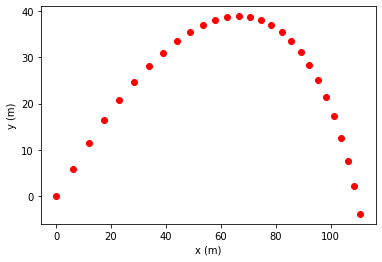

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Model parameters
M = 1.0          # Mass of projectile in kg
g = 9.8          # Acceleration due to gravity (m/s^2)
V = 80           # Initial velocity in m/s
V = float(throw['vt_msec'])           # Initial velocity in m/s
ang = 45.0       # Angle of initial velocity in degrees
Cd = float(throw['coeff_drag'])       # Drag coefficient
Cl = float(throw['magnus'])



# You can check the variables by printing them out
print( V, ang)

# Set up the lists to store variables
# Initialize the velocity and position at t=0
t = [0]                         # list to keep track of time
vx = [V*np.cos(ang/180*np.pi)]  # list for velocity x and y components
vy = [V*np.sin(ang/180*np.pi)]
x = [0]                         # list for x and y position
y = [0]

# Drag force
drag=Cd*V**2                      # drag force 

# Acceleration components
# ax = [-(np.pi / 2) * P * R**2 * V * ((Cl * vy[0]) + (Cd * vx[0])) / 1000]
ax = [-(drag*np.cos(ang/180*np.pi))/M ]          
ay = [-g-(drag*np.sin(ang/180*np.pi)/M) ]

## Leave this out for students to try
# We can choose to have better control of the time-step here
dt = 0.2

# Use Euler method to update variables
counter = 0
while (y[counter] >= 0):                   # Check that the last value of y is >= 0
    t.append(t[counter]+dt)                # increment by dt and add to the list of time 
    
    
    
    # Update velocity
    vx.append(vx[counter]+dt*ax[counter])  # Update the velocity
    vy.append(vy[counter]+dt*ay[counter])

    # Update position
    x.append(x[counter]+dt*vx[counter])    
    y.append(y[counter]+dt*vy[counter])    

    # With the new velocity calculate the drag force and update acceleration
    vel = np.sqrt(vx[counter+1]**2 + vy[counter+1]**2)   # magnitude of velocity
    drag = Cd*vel**2                                   # drag force 
    ax.append(-(np.pi / 2) * P * R**2 * V * ((Cl * vy[0]) + (Cd * vx[0])) / 10_000)     
    ay.append(-g-(drag*np.sin(ang/180*np.pi)/M))
    # tqdm(ay.append(((np.pi / 2) * P * R**2 * V * ((Cl * vx[0]) - (Cd * vy[0])) - (M * g)) / 10_000))
    
    # Increment the counter by 1
    counter = counter +1

# Let's plot the trajectory
plt.plot(x,y,'ro')
plt.ylabel("y (m)")
plt.xlabel("x (m)")
   
# The last value of x should give the range of the projectile approximately.

print("Range of projectile is {:3.1f} m".format(x[counter]))


### Set up the variables at time zero

Next, we generate velocity of the projectile as a function of time. To do that, we create the following lists.

- list to store the values of time $t$
- list to store x-component of velocity $v_x$
- list to store y-component of velocity $v_y$
- list to store x-component of acceleration $a_x$
- list to store y-component of acceleration $a_y$

We start by putting in the initial velocity components $v_x = V \cos\theta$ and $v_y = V \sin\theta$  at $t=0$. 

To get the acceleration, we need to find the resultant force, which consists of the air drag $F_d$ and weight $W$.

$$ W = M g$$ 

and 

$$ F_d = C_d v^2 $$

The x and y components of the resultant force are given by

$$ F_x = - F_d \cos\theta \qquad \text{and} \qquad F_y = -Mg - F_d \sin\theta $$

where $\theta$ is the angle that the velocity forms with the positive x-axis. The force components follow the convention that they are positive when pointing to the right and upwards.

By Newton's second law, the acceleration of the projectile is thus given by

$$ a_x = - (F_d \cos\theta)/M \qquad \text{and} \qquad a_y = -g - (F_d \sin\theta)/M $$

Let's implement these steps to get the velocity, drag force, and acceleration at $t=0$.


In [62]:
−
π
2
ρr2
v(CLvy + CDvx)

-(np.pi / 2) * P * R**2 * vx * (
    (Cl * vy) + (Cd + vx)
)

SyntaxError: invalid character '−' (U+2212) (2905060580.py, line 1)

In [ ]:
type(np.pi)
type(P)
type(R**2)
type(vx)

list

In [ ]:
vx[0]

28.443370273228876

In [64]:
# Set up the lists to store variables
# Start by putting the initial velocities at t=0
t = [0]  # list to keep track of time
vx = [V * np.cos(ang / 180 * np.pi)]  # list for velocity x and y components
vy = [V * np.sin(ang / 180 * np.pi)]

# Drag force
drag = Cd * V**2  # drag force

# Create the lists for acceleration components
ax = [-(np.pi / 2) * P * R**2 * V * ((Cl * vy[0]) + (Cd * vx[0])) / 1000]
# ay = [((np.pi / 2) * P * R**2 * V * ((Cl * vx[0]) - (Cd * vy[0])) - (M * g)) / 1000]
# ax = [-(drag*np.cos(ang/180*np.pi))/M]
ay = [-g-(drag*np.sin(ang/180*np.pi)/M)]

# ax -26.211908901294613
# ay -36.01855890129461

# Print out some values to check
print(ax[0])
print(ay[0])
print(vx[0])
print(vy[0])

-28.664195374474296
-36.01855890129461
28.443370273228876
28.443370273228872


### Update the velocity for every time-step

To get the velocity at the next time step, we make use of the following approximation.

$$ a(t_{n}) = \frac{dv(t_{n})}{dt} \approx \frac{v(t_{n+1}) - v(t_n)}{\Delta t} $$

or 

$$ v(t_{n+1}) \approx v(t_n) +  a(t_n) \Delta t $$

This is just a very primitive way of doing integration of acceleration to get velocity. In the literature, this is known as Euler's method.

Let us calculate 10 sets of velocities for 10 time-steps. We will use a while-loop and keep a counter to count to 10.

t= [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0]
vx= [28.443370273228876, 21.277321429610303, 17.91350299305111, 15.862272595409717, 14.506389016042636, 13.539829686882504, 12.78283280946712, 12.114079088279066, 11.440109112669298, 10.678596390344236, 9.746724570081936, 8.550319414679123, 6.970354913308175, 4.842447015485285, 1.921403787623714, -2.186105368810614, -8.161139955424172, -17.291580783814872, -32.29456001251879, -59.79477514163559, -119.57682907536216]


Text(0.5, 0, 'time (s)')

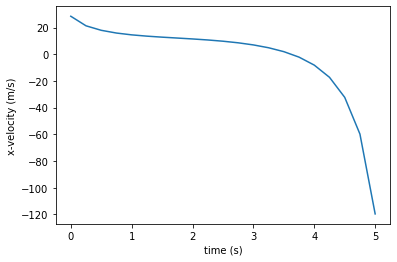

In [65]:
# Use Euler method to update variables
counter = 0
while (counter < 20):
    t.append(t[counter]+dt)                # increment by dt and add to the list of time 
    vx.append(vx[counter]+dt*ax[counter])  # Update the velocity
    vy.append(vy[counter]+dt*ay[counter])  

    # With the new velocity calculate the drag force
    vel = np.sqrt(vx[counter+1]**2 + vy[counter+1]**2)   # magnitude of velocity
    drag = Cd*vel**2                                   # drag force 
    ax.append(-(drag*np.cos(ang/180*np.pi))/M)     
    ay.append(-g-(drag*np.sin(ang/180*np.pi)/M))
    
    # Increment the counter by 1
    counter = counter +1

# Print the values to check
print("t=", t)
print("vx=", vx)

# Let's plot the velocity against time
plt.plot(t,vx)
plt.ylabel("x-velocity (m/s)")
plt.xlabel("time (s)")




### Update the positions

After we have obtained the velocities, we can get the $x$ and $y$ positions of the projectile using a similar concept.

$$ v_x(t_{n}) = \frac{dx(t_{n})}{dt} \approx \frac{x(t_{n+1}) - x(t_n)}{\Delta t} 
   \qquad \text{and} \qquad 
   v_y(t_{n}) = \frac{dy(t_{n})}{dt} \approx \frac{y(t_{n+1}) - y(t_n)}{\Delta t}
$$

or 

$$ x(t_{n+1}) \approx x(t_n) +  v_x(t_n) \Delta t 
   \qquad \text{and} \qquad 
   y(t_{n+1}) \approx y(t_n) +  v_y(t_n) \Delta t 
$$

Starting with $x=0$ and $y=0$ at $t=0$, we can use Euler's method to get the positions for the 10 time-steps using the velocities found previously.

Range of projectile is 39.6 m


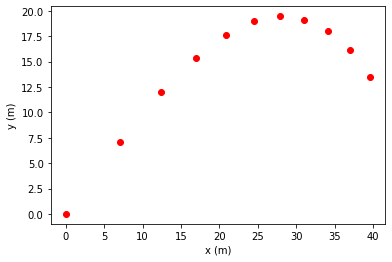

In [70]:
# Initialise the lists for x and y
x = [0]
y = [0]

# Use Euler method to update variables
counter = 0
while (counter < 10):
    # Update the positions x and y
    x.append(x[counter]+dt*vx[counter])    
    y.append(y[counter]+dt*vy[counter])    
    # Increment the counter by 1
    counter = counter +1


# Let's plot the trajectory
plt.plot(x,y,'ro')
plt.ylabel("y (m)")
plt.xlabel("x (m)")
print("Range of projectile is {:3.1f} m".format(x[counter]))

### Let's put everything together

How about calculating the velocity and position all together in the same while-loop? 

Also, let's stop the while-loop after the projectile drops back to the ground again. One simple way to detect this is to check whether the value of $y$ position falls below zero. So, we keep running the while-loop while $y \ge 0$.


### How far can the projectile go?

Try changing the initial velocity of the projectile and the drag coefficient to see how the trajectory changes.

Keeping the initial velocity magnitude fixed, find the initial velocity angle that will give the maximum range for a specific drag coefficient!


1
2
3
4
5
6
7
8
9
10
11


### Trivial

If you set the coefficient of drag to zero, can you get back the same trajectory you learned in Physics? Try checking the range of the projectile against the closed-form solution.